In [1]:
#importing dependencies 

import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import api_key

In [2]:
#importing csv files

filepath = "Resources/Item_Codes.csv"
item_codes_df = pd.read_csv(filepath)
item_codes_df

,SUB CATEGORY CODE,ITEM CODE,DESCRIPTION
0,ALCBEVG,ALCBEVG,Alcoholic beverages
1,APPAREL,APPAREL,Apparel and services
2,APPAREL,BOYS,"Apparel, Boys, 2 to 15"
3,APPAREL,FOOTWEAR,Footwear
4,APPAREL,GIRLS,"Apparel, Girls, 2 to 15"
...,...,...,...
149,TRANS,USEDCARS,"Vehicle purchases: Cars and trucks, used"
150,TRANS,VEHFINCH,Vehicle finance charges
151,TRANS,VEHOTHXP,Other vehicle expenses
152,TRANS,VEHPURCH,Vehicle purchases (net outlay)


In [3]:
# A single BLS API query can take up to 50 series ID at once. Since there are 153 item codes, 
# we created 4 nested lists of series IDs to request expenditure all item codes in 4 separate API queries
seriesids = [[],[],[],[]]

# Row counts tracks the limit of 50 elements per list. Set count tracks which nest list we're appending to.
setcount = 0
rowcount = 0

# Iterate through each row in the item_codes_df DataFrame
for index,row in item_codes_df.iterrows():
    # Move to the next nested series id list if the rowcount exceeds the API query limit of 50
    if rowcount == 50:
        setcount = setcount + 1
        rowcount = 0
    
    # Use the Item Code value in the DataFrame to modify the series ID and append the value to the list
    seriesids[setcount].append(f'CXU{row["ITEM CODE"]}LB0101M')
    
    # Iterate row count
    rowcount = rowcount + 1 
    
len(seriesids)

4

In [4]:
# Define header to post HTTP request
headers = {'Content-type': 'application/json'}

# Create a list to store the output of each API query
json_data = []

# Loop through the nested series ids to request up to 50 series IDs API per query
for i in range(len(seriesids)):
    data = json.dumps({"seriesid": seriesids[i],"startyear":"2010", "endyear":"2011","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data.append(json.loads(p.text))

In [5]:
# This cell is used to test accessing the elements stored in the bls json reponse
len(json_data[1]["Results"]['series'][22]['data'])

2

In [6]:
# Initialize set and row count with the same meaning as above
rowcount = 0
setcount = 0

# Initialize lists that will be used as columns in the new DataFrame 
item_year = []
item_value = []
item_cat = []
item_desc = []

for i in range(len(item_codes_df)):
    if rowcount == 50:
        setcount = setcount + 1
        rowcount = 0
    
    # Iterate through the number of years in the API query
    for j in range(len(json_data[1]["Results"]['series'][22]['data'])):
        
        # Attempts to return the year and value from the json API reponse
        try:
            item_year.append(json_data[setcount]["Results"]['series'][rowcount]['data'][j]['year'])
            item_value.append(float(json_data[setcount]["Results"]['series'][rowcount]['data'][j]['value']))
            item_cat.append(item_codes_df.iloc[i,0])
            item_desc.append(item_codes_df.iloc[i,2])
        # If fails, add a null value to the list (all lists need to be the same size when creating the DataFrame)
        except:
            print(f"Item {i} doesn't have data")
        
        # Create list for item category and item description for the new DataFrame
        
        
    # Iterate row count
    rowcount = rowcount + 1
 
# Create new DataFrame with one column for year
item_data_df = pd.DataFrame({"Category": item_cat,
                             "Item":item_desc,
                             "Year": item_year,
                             "Value": item_value
})

item_data_df

Item 20 doesn't have data
Item 20 doesn't have data
Item 22 doesn't have data
Item 22 doesn't have data
Item 24 doesn't have data
Item 24 doesn't have data
Item 57 doesn't have data
Item 57 doesn't have data
Item 80 doesn't have data
Item 80 doesn't have data
Item 91 doesn't have data
Item 91 doesn't have data
Item 114 doesn't have data
Item 114 doesn't have data
Item 134 doesn't have data
Item 134 doesn't have data
Item 135 doesn't have data
Item 135 doesn't have data
Item 136 doesn't have data
Item 136 doesn't have data
Item 137 doesn't have data
Item 137 doesn't have data
Item 138 doesn't have data
Item 138 doesn't have data


,Category,Item,Year,Value
0,ALCBEVG,Alcoholic beverages,2011,456.0
1,ALCBEVG,Alcoholic beverages,2010,412.0
2,APPAREL,Apparel and services,2011,1740.0
3,APPAREL,Apparel and services,2010,1700.0
4,APPAREL,"Apparel, Boys, 2 to 15",2011,80.0
...,...,...,...,...
279,TRANS,Other vehicle expenses,2010,2464.0
280,TRANS,Vehicle purchases (net outlay),2011,2669.0
281,TRANS,Vehicle purchases (net outlay),2010,2588.0
282,TRANS,"Vehicle. rent., leas., licen., oth. charges",2011,433.0


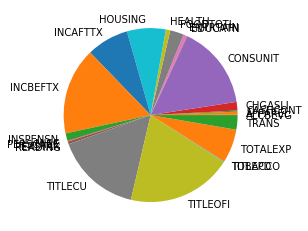

ALCBEVG      0.055576
APPAREL      0.579454
CASHCONT     0.214750
CHGASLI      1.580021
CONSUNIT    15.584055
EDUCATN      0.136060
ENTRTAIN     0.650077
FOODTOTL     2.561252
HEALTH       0.828524
HOUSING      7.203545
INCAFTTX     7.836079
INCBEFTX    16.156274
INSPENSN     1.382495
MISC         0.103982
PERSCARE     0.077858
PERSTAX      0.484116
READING      0.013766
TITLECU     15.921438
TITLEOFI    19.541952
TITLEPD      0.083749
TOBACCO      0.045652
TOTALEXP     6.262844
TRANS        2.696479
Name: Value, dtype: float64


In [8]:
cat_df = item_data_df.groupby([item_cat])
cat_sum = cat_df["Value"].sum()
plt.pie(cat_sum,labels=cat_sum.index)
plt.show()
cat_sum = cat_df["Value"].sum()
total = cat_sum.sum()
print(cat_sum/total*100)
